# Multibeam Frequency Shifter - https://doi.org/10.1364/OE.498792

Below, one can find a shematic of a 16-by-5 multibeam concept. By applying a wavelike modulation to the modulators, we can mimick acousto optic like modulation characteristics and hereby split the sideband frequencyies towards different directions. A star coupler can collect then these different directions and freqquencies.

<img src="images\shematic_working_priciple.jpg" alt="Image" width="50%" height="50%">

In [8]:
import numpy as np
import gdsfactory as gf

from gdsfactory.cross_section import strip
from gdsfactory.typings import ComponentSpec, CrossSectionSpec, LayerSpec
from gdsfactory.generic_tech import get_generic_pdk

import gplugins.tidy3d as gt
from gplugins.config import PATH
from gplugins import utils
from tidy3d import web
import tidy3d as td
import matplotlib.pyplot as plt
from simulation import get_structures, get_monitors, get_sources, get_sparam

gf.config.rich_output()

PDK = get_generic_pdk()
PDK.activate()


2023-08-28 16:57:59.926 | INFO     | gdsfactory.technology.layer_views:__init__:810 - Importing LayerViews from YAML file: 'c:\\Users\\edieussa\\anaconda3\\envs\\environment\\Lib\\site-packages\\gdsfactory\\generic_tech\\layer_views.yaml'.
2023-08-28 16:57:59.935 | INFO     | gdsfactory.pdk:activate:317 - 'generic' PDK is now active


## Modulation 

The choice of modulators determines the distribution of harmonics. For simplicity, here we will choose sine phase modulation. 
By adding a delay to the modulation of consecutive elements of a modulator array with equidistant aperture outputs, wavelike modulation can be mimicked. 

todo: - show modulation 
      - show delay adds phase shift?


## Star Coupler
In order to efficiently collect the sidebands, a star coupler can be used. Here we consider a 16-by-5 frequency shifter and below we show the design of a 16-by-5 star coupler in gdsfactory

#### Aperture
The aperture determines the spreading angle or numerical aperture of the in and outputs. We try to fill this angle as well as possible for the output apertures.



In [9]:
ap = gf.Component("aperture")
P = gf.Path()
P.append(gf.path.straight(length=10))


X1=gf.CrossSection(width=0.5,
                    offset=0,
                    layer='WG',
                    name='wg',
                    sections = [])

X2=gf.CrossSection(width=2,
                    offset=0,
                    layer='WG',
                    name='wg',
                    sections = [])

# Create the transitional CrossSection
Xtrans = gf.path.transition(cross_section1=X1, cross_section2=X2, width_type="sine")
# Create a Path for the transitional CrossSection to follow
P3 = gf.path.straight(length=10., npoints=100)
# Use the transitional CrossSection to create a Component
straight_transition = gf.path.extrude(P3, Xtrans)
ap << straight_transition
aperture_components = {
    "aperture": straight_transition
}
x= straight_transition.rotate(0)

x
scene = x.to_3d()
scene.show()

c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\gdsfactory\component.py:179: UserWarning: Component name aperture already used. Use @cell decorator for auto-naming.
  warnings.warn(
2023-08-28 16:58:03.176 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


trimesh: threejs viewer

2023-08-28 16:58:07.589 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?
c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWarning: invalid value encountered in scalar multiply
  max_offset += max(0, abs(self._tanq) * self.length_axis / 2)


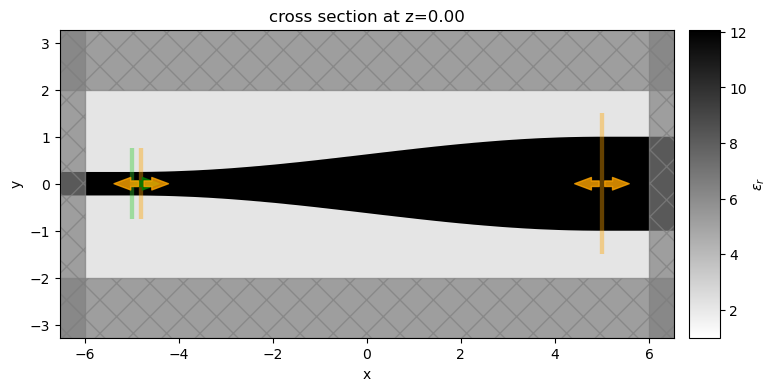

In [10]:
sim = gt.get_simulation(x, is_3d=False)
fig = gt.plot_simulation(sim)

2023-08-28 16:58:12.397 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?
c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWarning: invalid value encountered in scalar multiply
  max_offset += max(0, abs(self._tanq) * self.length_axis / 2)


[16:58:12] WARNING: Use the remote mode solver with subpixel averaging for better accuracy       ]8;id=51761;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\plugins\mode\mode_solver.py\mode_solver.py]8;;\:]8;id=982720;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\plugins\mode\mode_solver.py#125\125]8;;\
           through 'tidy3d.plugins.mode.web.run(...)'.                                                             

Effective index of computed modes:  [[3.2938435 3.185523 ]]


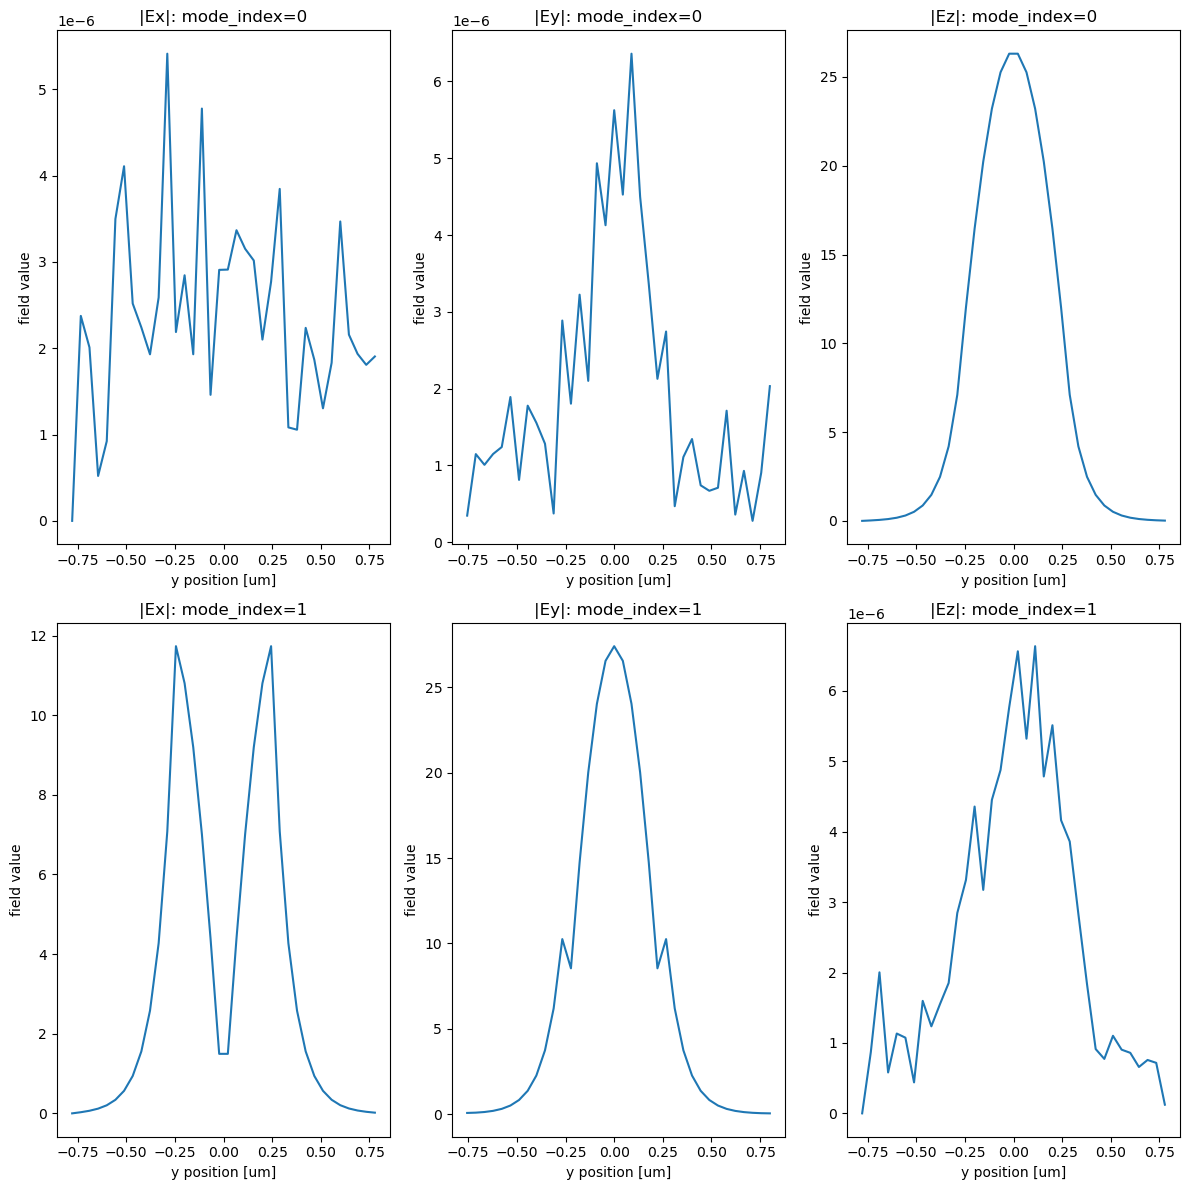

In [11]:
sim = gt.get_simulation(x, is_3d=False, plot_modes=True, num_modes=2)

2023-08-25 12:50:05.512 | INFO     | gplugins.tidy3d.write_sparameters:write_sparameters:174 - Simulation loaded from WindowsPath('../sparameters/aperture.npz')


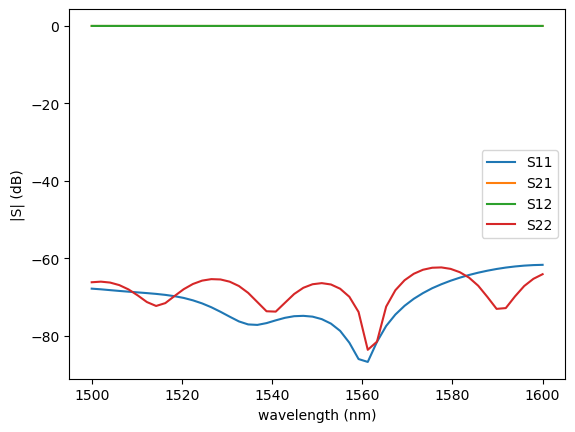

ValueError: 'o1@1,o2@1' not in ['o1@0,o1@0', 'wavelengths', 'o2@0,o1@0', 'o1@0,o2@0', 'o2@0,o2@0']

In [114]:

sp_ap = gt.write_sparameters(x, filepath='..\\sparameters\\aperture.npz')
utils.plot.plot_sparameters(sp_ap)
utils.plot.plot_sparameters(sp_ap, keys=("o1@1,o2@1",))


In [12]:
@gf.cell
def star_coupler(
    num_in: int = 16,
    num_out: int = 5,
    rowland_r: float = 46.25,
    pitch_angle_in: float = 1.64,
    pitch_angle_out: float = 3.76,
    aperture_in: str = "aperture",
    cross_section_ap: CrossSectionSpec = 'strip',
    port_ap_width: float = 2.,
    layer_slab: LayerSpec = 'WG'
    ) -> gf.Component:
    """Free propagation region.
    .. code::
                 length
                 <-->
                   /|
                  / |
           width1|  | width2
                  \ |
                   \|
    """
    length_extension = 3.  # keep minimum 4
    length_straight = 1.

    # aperture in
    angles_in = np.linspace(-(num_in-1)/2*pitch_angle_in,+(num_in-1)/2*pitch_angle_in, num_in)
    yports_in = 2*rowland_r*np.sin(np.deg2rad(angles_in))
    xports_in = rowland_r-2*rowland_r*np.cos(np.deg2rad(angles_in))
    pitch_in = 4.*rowland_r*np.sin(np.deg2rad(pitch_angle_in/2.))

    # apertures out
    angles_out = np.linspace(-(num_out-1)/2.*pitch_angle_out,(num_out-1)/2.*pitch_angle_out, num_out)
    yports_out = rowland_r*np.sin(np.deg2rad(angles_out))
    xports_out = rowland_r*np.cos(np.deg2rad(angles_out))
    pitch_out =  2.*rowland_r*np.sin(np.deg2rad(pitch_angle_out)/2.)

    # create FPR
    extension_in = 2.
    x_polygon_in = xports_in - pitch_in / 2. * np.sin(np.deg2rad(angles_in))
    x_polygon_in = np.append(x_polygon_in, xports_in[-1] + extension_in * np.sin(np.deg2rad(angles_in[-1])))
    x_polygon_in = np.insert(x_polygon_in, 0, xports_in[0] - extension_in * np.sin(np.deg2rad(angles_in[0])),)
    y_polygon_in = yports_in - pitch_in / 2. * np.cos(np.deg2rad(angles_in))
    y_polygon_in = np.append(y_polygon_in, yports_in[-1] + extension_in * np.cos(2*np.deg2rad(angles_in[-1])))
    y_polygon_in = np.insert(y_polygon_in, 0,  yports_in[0] - extension_in * np.cos(2*np.deg2rad(angles_in[0])))

    extension_out = 5.
    x_polygon_out = xports_out + pitch_out / 2. * np.sin(np.deg2rad(angles_out))
    x_polygon_out = np.append(x_polygon_out, xports_out[-1] - extension_out * np.sin(np.deg2rad(angles_out[-1])))
    x_polygon_out = np.insert(x_polygon_out, 0, xports_out[0] + extension_out * np.sin(np.deg2rad(angles_out[0])))
    y_polygon_out = yports_out - pitch_out / 2. * np.cos(np.deg2rad(angles_out))
    y_polygon_out = np.append(y_polygon_out, yports_out[-1] + extension_out * np.cos(np.deg2rad(angles_out[-1])))
    y_polygon_out = np.insert(y_polygon_out, 0,  yports_out[0] - extension_out * np.cos(np.deg2rad(angles_out[0])))

    x_polygon = np.concatenate([x_polygon_in, np.flip(x_polygon_out)])
    y_polygon = np.concatenate([y_polygon_in, np.flip(y_polygon_out)])

    polygon_tuples = []
    for i in range(np.size(x_polygon)):
        polygon_tuples.append((x_polygon[i],y_polygon[i]))

    sc = gf.Component()
    slab = gf.Component()
    slab.add_polygon(polygon_tuples, layer=layer_slab)
    
    aperture_component = aperture_components[aperture_in]
    
    ap_ports = []
    straight_ports = []

    for i, angle_i in enumerate(angles_in):
        slab.add_port(
        f"W{i}",
        center=(xports_in[i],yports_in[i]),
        width = port_ap_width,
        orientation = 180.-angle_i,
        layer=layer_slab
        )
        aperture = sc.add_ref(aperture_component)
        aperture.connect("o2", destination=slab.ports[f"W{i}"])
        slab = gf.geometry.boolean(slab, aperture, operation="A-B", precision=1e-12)
        
        straight_ref = sc << gf.components.straight(length=length_straight, cross_section=cross_section_ap)
        straight_ref.move((aperture.ports["o1"].x-length_extension*np.cos(np.deg2rad(angle_i))-length_extension
                           , aperture.ports["o1"].y+length_extension*np.sin(np.deg2rad(angle_i))))
        
        # to enable ports at the input of the aperture:  
        # sc.add_port(f"o{i}", port=straight_ref.ports["o1"])

        ap_ports.append(aperture.ports["o1"])
        straight_ports.append(straight_ref.ports["o2"])

        # to put ports at the slab input (for simulation) 
        sc.add_port(
        f"W{i}",
        center=(xports_in[i],yports_in[i]),
        width = port_ap_width,
        orientation = 180.-angle_i,
        layer=layer_slab
        )
    
    
    routes = gf.routing.get_bundle_all_angle(ap_ports, straight_ports,cross_section= cross_section_ap)
    for route in routes:
        sc.add(route.references)
    
    ap_port = []
    straight_ports = []

    for i, angle_i in enumerate(angles_out):
        slab.add_port(
        f"E{i}",
        center=(xports_out[i],yports_out[i]),
        width = port_ap_width,
        orientation = angle_i,
        layer=layer_slab
        )
        aperture = sc.add_ref(aperture_component)
        aperture.connect("o2", destination=slab.ports[f"E{i}"])
        slab = gf.geometry.boolean(slab, aperture, operation="A-B", precision=1e-12)

        straight_ref = sc << gf.components.straight(length=length_straight, cross_section=cross_section_ap)
        straight_ref.move((aperture.ports["o1"].x+length_extension*np.cos(np.deg2rad(angle_i))+length_straight, aperture.ports["o1"].y+length_extension*np.sin(np.deg2rad(angle_i))))
        
        # to enable ports at the end of the aperture: 
        #sc.add_port(f"o{i+num_in}", port=straight_ref.ports["o2"])
        ap_port.append(aperture.ports["o1"])
        straight_ports.append(straight_ref.ports["o1"])

        # to enable ports at the slab outputs (for simulation)
        sc.add_port(
        f"E{i}",
        center=(xports_out[i],yports_out[i]),
        width = port_ap_width,
        orientation = angle_i,
        layer=layer_slab
        )

    routes2 = gf.routing.get_bundle_all_angle(straight_ports, ap_port, end_cross_section=cross_section_ap )
    for route2 in routes2:
        sc.add(route2.references)

        

    slab = gf.geometry.offset(slab, distance = 0.1, precision = 1e-9, layer=layer_slab)
    sc.auto_rename_ports()
    sc << slab
    return sc


c = star_coupler()
c.show(show_ports=True)



#c.get_ports()[20].orientation
#c
#c.write_gds('starcoupler.gds')
#scene = c.to_3d()
#scene.show()
#c.ports

c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\gdsfactory\show.py:40: UserWarning: Component 'Unnamed_1491987e' contains 1 Unnamed cells
  gdspath = component.write_gds(
2023-08-28 16:58:20.874 | WARNING  | gdsfactory.klive:show:48 - Could not connect to klive server. Is klayout open and klive plugin installed?


type='ModeSource' center=(46.75, 0.0, 0.0) size=(0.0, 3.0, inf) source_time=GaussianPulse(amplitude=1.0, phase=0.0, type='GaussianPulse', freq0=193414489032258.06, fwidth=19341448903225.805, offset=5.0) name='o19' num_freqs=1 direction='+' mode_spec=ModeSpec(num_modes=1, target_neff=None, num_pml=(0, 0), filter_pol=None, angle_theta=3.141592653589793, angle_phi=0.0, precision='single', bend_radius=None, bend_axis=None, track_freq='central', group_index_step=False, type='ModeSpec') mode_index=1


c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\components\geometry.py:2964: RuntimeWarning: invalid value encountered in scalar multiply
  max_offset += max(0, abs(self._tanq) * self.length_axis / 2)


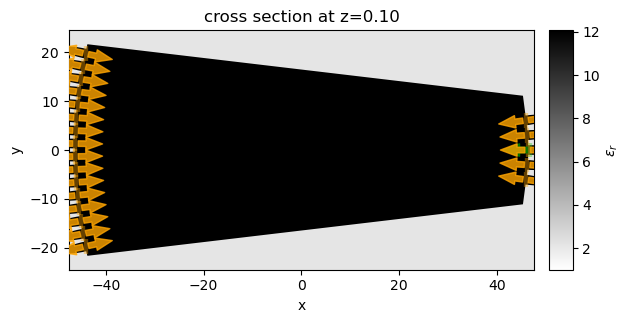

In [25]:
rowland_r=46.25
c = star_coupler(rowland_r=rowland_r)
#print(c.ports)
size = [2*rowland_r+2.,rowland_r+1.,0]

structures = get_structures(c, is_3d=False)
monitors = get_monitors(c, is_3d=False, domain_size=size)
sources = get_sources(c,is_3d=False,port_source_names=["o19"], source_offset=0.5,num_modes=2,mode_index=1)
print(sources)
sim = td.Simulation(
    size = size,
    structures= structures,
    sources=[sources],
    monitors=monitors,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=1.55),
    run_time=1e-11,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.pml(), y=td.Boundary.pml(), z=td.Boundary.periodic()),
    shutoff=1e-9
    )

sim.plot_eps(z=0.1, freq=td.C_0/1.55)



In [32]:
#task_id = web.upload(sim, task_name="sim_o19")
print("Max flex unit cost: ", web.estimate_cost(task_id))
#sim.help
sim.to_file(fname='sim.json') 

Max flex unit cost:  0.2903112644411646


In [27]:
web.start(task_id)
web.monitor(task_id, verbose = True)

[17:30:33] status = queued                                                                            ]8;id=735550;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=430494;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#363\363]8;;\

Output()

[17:30:37] status = preprocess                                                                        ]8;id=286445;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=258462;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#357\357]8;;\

[17:30:42] Maximum FlexCredit cost: 0.290. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=856167;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=4965;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#343\343]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=411877;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=843568;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#379\379]8;;\

           running solver                                                                             ]8;id=922396;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=472110;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#389\389]8;;\

           To cancel the simulation, use 'web.delete(task_id)' or delete the task in the web UI.      ]8;id=986349;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=774811;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#390\390]8;;\
           Terminating the Python script will not stop the job running on the cloud.                               

Output()

[17:34:36] early shutoff detected, exiting.                                                           ]8;id=317257;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=369571;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#407\407]8;;\

           status = queued                                                                            ]8;id=1519;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=853463;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#424\424]8;;\

Output()

[17:34:40] status = preprocess                                                                        ]8;id=407225;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=935804;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#431\431]8;;\

[17:34:45] status = running                                                                           ]8;id=991106;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=733008;file://c:\Users\edieussa\anaconda3\envs\environment\Lib\site-packages\tidy3d\web\webapi.py#431\431]8;;\

KeyboardInterrupt: 

In [15]:
#print("Billed flex unit cost: ", web.real_cost(task_id))
sim_data = web.load(task_id, path="data/sim_data.hdf5")
# Show the output of the log file
print(sim_data.log)

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [ ]:
get_sparam(port_out="o1",sim_data = sim_data, sim = sim)